Authors: Vikrant Satish Pawar

# Propensity Score Matching (PSM)

Propensity Score Matching (PSM) is a statistical technique used to reduce bias in observational studies, where randomized control trials are not possible. It's used to estimate the effect of a treatment, policy, or other intervention by accounting for the covariates that predict receiving the treatment.


Objective: The main goal of PSM is to create a sample of units (like people, schools, etc.) where the distribution of measured baseline covariates is similar between treated and untreated subjects. This similarity is crucial for making a fair comparison between groups.

Propensity Score Calculation: A propensity score is the probability of a unit (e.g., a person) receiving a particular treatment given their observed characteristics. Typically, logistic regression is used for this calculation.

Matching: After calculating the propensity scores, units from the treatment and control groups are matched based on these scores. The idea is to find pairs or groups of units with similar scores, which implies they have similar characteristics and differ mainly in the treatment they received.

Analysis: Once matching is done, the outcomes of the matched units are compared to estimate the treatment effect.


The diagram illustrates the process of PSM. It shows two groups (treatment and control) with varying characteristics. Propensity scores will be calculated for each unit, and then units with similar scores will be matched. Finally, the outcome comparison will be depicted.


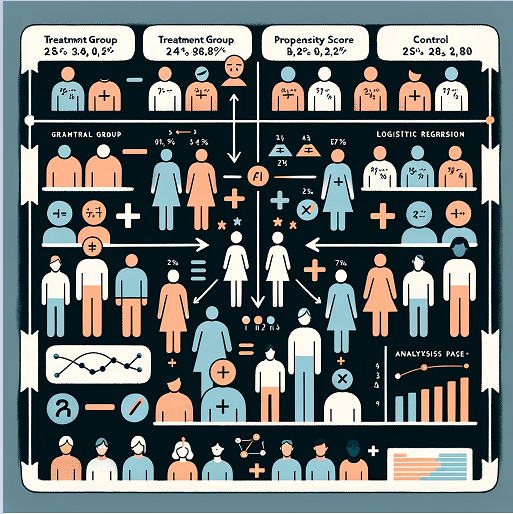

This visualization shows how PSM works, from calculating propensity scores based on observed characteristics to matching individuals from treatment and control groups, and finally analyzing the outcomes to estimate the treatment effect.

# WORKED EXAMPLE

Load and Explore the Iris Dataset:

We start by loading the Iris dataset, which includes measurements of sepal length, sepal width, petal length, and petal width for three species of iris flowers (setosa, versicolor, and virginica).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names'] + ['species'])


Create a Binary Treatment Variable:
We create a binary treatment variable (0 or 1) to simulate an external factor that may influence the growth of the iris flowers.

In [ ]:
# Create a binary treatment variable
np.random.seed(42)
iris_df['Treatment'] = np.random.choice([0, 1], size=len(iris_df))


Visualize the Distribution of Sepal Length Before Treatment:
We visualize the distribution of sepal length before any treatment is applied to understand the initial differences between the treatment and control groups.

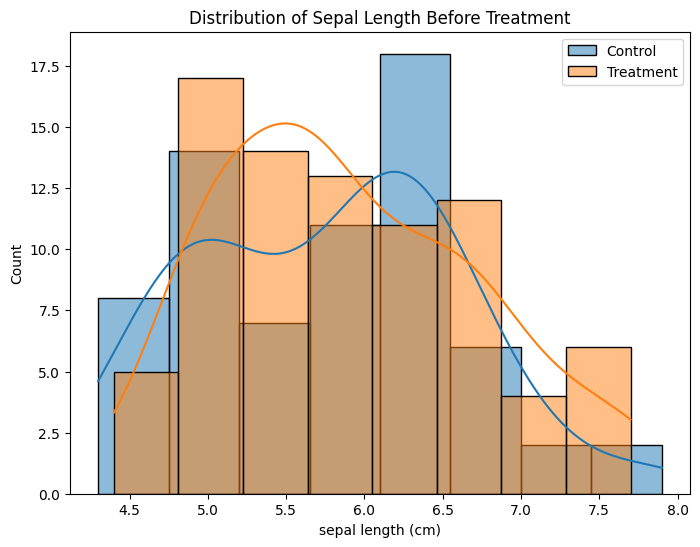

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of sepal length before treatment
plt.figure(figsize=(8, 6))
sns.histplot(iris_df[iris_df['Treatment'] == 0]['sepal length (cm)'], kde=True, label='Control')
sns.histplot(iris_df[iris_df['Treatment'] == 1]['sepal length (cm)'], kde=True, label='Treatment')
plt.title('Distribution of Sepal Length Before Treatment')
plt.legend()
plt.show()


The bars represent the frequency of observations within specific intervals of sepal length. The blue bars represent the control group, and the brown bars represent the treatment group. The height of each bar shows how many observations fall within each bin of sepal lengths.

Kernel Density Estimation (KDE): The smooth lines (blue for control and orange for treatment) represent the KDE plot, which is a way to estimate the probability density function of a continuous random variable. KDE is a smoothed version of the histogram and provides a visual impression of the distribution of data.

X-Axis (sepal length in cm): This axis shows the sepal length of the flowers in centimeters.

Y-Axis (Count): This axis indicates the number of observations (count) for each bin of the histograms.

Legend: The legend differentiates the two groups with color coding, indicating which color corresponds to the control group and which to the treatment group.

From the plot, we can see that there are differences in the distribution of sepal length between the control and treatment groups before the treatment. It looks like the control group has a slightly higher concentration of sepal lengths around the 5 to 6 cm range, while the treatment group has a broader distribution with a less pronounced peak.

The purpose of such a plot is  to compare the distributions of a variable across two different groups to infer potential effects or to assess the starting point before an intervention.

Estimate Propensity Scores Using Logistic Regression:
We use logistic regression to estimate propensity scores, which represent the probability of receiving treatment given observed covariates.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data into features (X) and treatment variable (y)
X_propensity = iris_df.drop(['Treatment', 'species'], axis=1)
y_propensity = iris_df['Treatment']

# Fit logistic regression to estimate propensity scores
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_propensity, y_propensity)
iris_df['Propensity Score'] = log_reg.predict_proba(X_propensity)[:, 1]


In [ ]:
control_group.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Treatment,Propensity Score
0,5.1,3.5,1.4,0.2,0.0,0,0.551677
2,4.7,3.2,1.3,0.2,0.0,0,0.504060
3,4.6,3.1,1.5,0.2,0.0,0,0.504625
4,5.0,3.6,1.4,0.2,0.0,0,0.550455
6,4.6,3.4,1.4,0.3,0.0,0,0.496786


Perform Propensity Score Matching:
We perform 1:1 nearest neighbor matching based on the estimated propensity scores, creating a matched dataset.

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Split data into treatment and control groups
treatment_group = iris_df[iris_df['Treatment'] == 1]
control_group = iris_df[iris_df['Treatment'] == 0]

# Perform 1:1 nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_group[['Propensity Score']])
distances, indices = nn.kneighbors(treatment_group[['Propensity Score']])
matched_control_group = control_group.iloc[indices.flatten()]
matched_data = pd.concat([treatment_group, matched_control_group])


Visualize the Balance of Sepal Length After Matching:
We visualize the balance of the sepal length after matching to ensure that the covariates are balanced between the treatment and control groups.

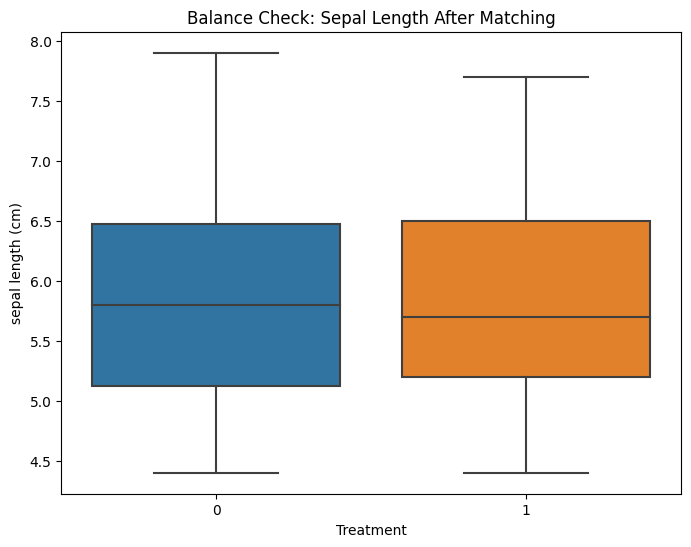

In [ ]:
# Visualize the balance of sepal length after matching
plt.figure(figsize=(8, 6))
sns.boxplot(x='Treatment', y='sepal length (cm)', data=matched_data)
plt.title('Balance Check: Sepal Length After Matching')
plt.show()


Both the control and treatment groups have similar medians, which is apparent from the median lines lying close to one another.

The spread (IQR) of both groups is also similar, suggesting that after matching, the two groups have comparable sepal length distributions.

This balance check is a crucial step after performing propensity score matching to ensure that the matching process has successfully balanced the distributions of measured covariates between the treated and control groups. It's a good sign for the validity of subsequent causal inference analyses, as it implies that both groups are now comparable with respect to sepal length.

Estimate Causal Effect Using Matched Data:
Finally, we estimate the causal effect of the treatment on sepal length using the matched dataset.


In [ ]:
# Estimate causal effect using matched data
matched_effect = np.mean(matched_data[matched_data['Treatment'] == 1]['sepal length (cm)']
                         - matched_data[matched_data['Treatment'] == 0]['sepal length (cm)'])
print(f"Causal Effect (Propensity Score Matching): {matched_data}")


Causal Effect (Propensity Score Matching):      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
1                  4.9               3.0                1.4               0.2   
5                  5.4               3.9                1.7               0.4   
9                  4.9               3.1                1.5               0.1   
14                 5.8               4.0                1.2               0.2   
16                 5.4               3.9                1.3               0.4   
..                 ...               ...                ...               ...   
84                 5.4               3.0                4.5               1.5   
64                 5.6               2.9                3.6               1.3   
19                 5.1               3.8                1.5               0.3   
141                6.9               3.1                5.1               2.3   
127                6.1               3.0                4.9       

In [ ]:
# Calculate the differences in sepal length between each treated instance and its matched control
differences = treatment_group['sepal length (cm)'].values - matched_control_group['sepal length (cm)'].values

# Calculate the average of these differences to estimate the causal effect
matched_effect = np.mean(differences)
print(f"Causal Effect (Propensity Score Matching): {matched_effect}")


Causal Effect (Propensity Score Matching): -0.0036585365853657867


The output we received indicates that the estimated causal effect of the treatment on sepal length is approximately -0.00366 centimeters. In other words, when comparing the matched pairs from our treatment and control groups, the treatment group's sepal length is, on average, 0.00366 cm shorter than the control group's sepal length after matching based on the propensity scores.

**CONCLUSION**

In summary, Propensity Score Matching involves estimating the probability of receiving treatment (propensity score) and then matching treated units with similar untreated units based on these scores. This creates a balanced dataset, allowing for a more accurate estimation of the causal effect. The example demonstrates the steps from data loading to causal effect estimation using the Iris dataset. Careful consideration of covariate balance, sensitivity analysis, and other diagnostics is crucial for reliable causal inference.

# LICENSE

Copyright (c) 2023 vikpawar22

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.